# Tugas Besar Image Classification

Penyakit Alzheimer merupakan salah satu jenis penyakit neurodegeneratif. Penyakit neurodegeneratif ini menyebabkan gangguan kognitif dengan gejala awal gangguan daya ingat. Penanganan yang tepat memerlukan penentuan tahapan keparahan penyakit secara akurat, yaitu dengan menggunakan hasil MRI otak. Berdasarkan dataset yang kami gunakan tahapan keparahan Alzheimer dibagi menjadi 4 kelas, antara lain: Non-Demented, Mild Demented, Moderate Demented, dan Very Mild Demented. Untuk keperluan identifikasi tahapan keparahan penyakit, dapat dikembangkan sistem klasifikasi diagnosis tingkat keparahan alzheimer berdasarkan hasil MRI.

Anggota Kelompok:
* I Ketut Yasa Seniarta (​​1301210557)
* Natalie Diva Krisantya (1301213308)
* Maritza Amalia Dwiputri (1301213399)



## Import Libraries

In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf
import keras

print("Versi TensorFlow:", tf.__version__)
print("Versi Keras:", keras.__version__)

Versi TensorFlow: 2.15.0
Versi Keras: 2.15.0


In [ ]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import files

## Dataset Preparation

Dataset diambil dari kaggle https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/data

Data ini berisikan 6400 citra yang terbagi menjadi 4 kelas yaitu
* Class - 1: Mild Demented (896 images)
* Class - 2: Moderate Demented (64 images)
* Class - 3: Non Demented (3200 images)
* Class - 4: Very Mild Demented (2240 images)

In [3]:
!pip install -q kaggle

In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maritzacaca17","key":"a1c37256df030453573be515c61a17e4"}'}

In [6]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset
License(s): copyright-authors
alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!unzip alzheimer-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Non_Demented/non_1395.jpg  
  inflating: Dataset/Non_Demented/non_1396.jpg  
  inflating: Dataset/Non_Demented/non_1397.jpg  
  inflating: Dataset/Non_Demented/non_1398.jpg  
  inflating: Dataset/Non_Demented/non_1399.jpg  
  inflating: Dataset/Non_Demented/non_14.jpg  
  inflating: Dataset/Non_Demented/non_140.jpg  
  inflating: Dataset/Non_Demented/non_1400.jpg  
  inflating: Dataset/Non_Demented/non_1401.jpg  
  inflating: Dataset/Non_Demented/non_1402.jpg  
  inflating: Dataset/Non_Demented/non_1403.jpg  
  inflating: Dataset/Non_Demented/non_1404.jpg  
  inflating: Dataset/Non_Demented/non_1405.jpg  
  inflating: Dataset/Non_Demented/non_1406.jpg  
  inflating: Dataset/Non_Demented/non_1407.jpg  
  inflating: Dataset/Non_Demented/non_1408.jpg  
  inflating: Dataset/Non_Demented/non_1409.jpg  
  inflating: Dataset/Non_Demented/non_141.jpg  
  inflating: Dataset/Non_Demented/non_1410.jpg  
  inflating: Dataset/N

## Pre Process

### Split, Resize and Normalization

Pada tahap ini dilakukan splitting data menjadi train set dan validation set menggunakan image_dataset_from_directory. Fungsi ini meminta seberapa besar pemabagian (split) yang ditunjukkan dengan 'validation_split'. Lalu di sini juga dilakukan resizing menjadi 224x224. Image_dataset_from_directory juga secara otomatis akan melakukan normalisasi data dengan formula 1./255.

In [ ]:
PATH = "/content/Dataset/"

BATCH_SIZE = 32
IMG_SIZE = 224

train_set = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

valid_set = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

### Class Weighting

In [14]:
CLASSES = train_set.class_names

count = np.zeros(len(CLASSES), dtype=np.int32)
for _, labels in train_set:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
class_weight = dict(enumerate(count))

AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


### Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    return data_augmentation(image), label

train_set = train_set.map(augment, num_parallel_calls=AUTOTUNE)

## Training

### Base Model

In [16]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

### Model 1

In [ ]:
dropout_rate = 0.4
NUM_CLASSES = 4

model = models.Sequential(name="SimpleReLUwithEfficientNetB7")
model.add(base_model)
model.add(layers.GlobalMaxPooling2D(name="gap"))
model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(1024, activation='relu', name="fc1"))
model.add(layers.Dense(NUM_CLASSES, activation='softmax', name="fc_out"))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "SimpleReLUwithEfficientNetB7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 2560)              0         
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dropout_out (Dropout)       (None, 2560)              0         
                                                                 
 fc1 (Dense)                 (None, 1024)              2622464   
                                                                 
 fc_out (Dense)              (None, 4)                 4100      
                                      

In [ ]:
training_history = model.fit(train_set, validation_data=VALID_DS, epochs=10, class_weight=class_weight)
results = pd.DataFrame({
    "Training Accuracy": training_history.history['accuracy'],
    "Validation Accuracy": training_history.history['val_accuracy'],
    "Training Loss": training_history.history['loss'],
    "Validation Loss": training_history.history['val_loss']
})

Epoch 1/10
160/160 [==============================] - 166s 849ms/step - loss: 2451.9663 - accuracy: 0.4770 - val_loss: 1.0613 - val_accuracy: 0.5656
Epoch 2/10
160/160 [==============================] - 85s 528ms/step - loss: 1950.4001 - accuracy: 0.5012 - val_loss: 1.0165 - val_accuracy: 0.5672
Epoch 3/10
160/160 [==============================] - 98s 613ms/step - loss: 1812.1608 - accuracy: 0.5068 - val_loss: 1.0127 - val_accuracy: 0.5367
Epoch 4/10
160/160 [==============================] - 89s 551ms/step - loss: 1722.1726 - accuracy: 0.5150 - val_loss: 0.9439 - val_accuracy: 0.5453
Epoch 5/10
160/160 [==============================] - 85s 528ms/step - loss: 1607.5962 - accuracy: 0.5312 - val_loss: 0.9090 - val_accuracy: 0.5688
Epoch 6/10
160/160 [==============================] - 83s 517ms/step - loss: 1595.9529 - accuracy: 0.5266 - val_loss: 0.9238 - val_accuracy: 0.5641
Epoch 7/10
160/160 [==============================] - 82s 511ms/step - loss: 1568.1038 - accuracy: 0.5340 - val

In [ ]:
model.save('model_simplerelu_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 2

In [ ]:
model_2 = models.Sequential(name="DeepReLUwithEfficientNetB7")
model_2.add(base_model)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(4096, activation='relu'))
model_2.add(layers.Dense(1024, activation='relu'))
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(len(CLASSES), activation='softmax'))

In [ ]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "DeepReLUwithEfficientNetB7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 125440)            0         
                                                                 
 dense (Dense)               (None, 4096)              513806336 
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                        

In [14]:
training_history_2 = model_2.fit(TRAIN_DS, validation_data=VALID_DS, epochs=10, class_weight=class_weight)
results = pd.DataFrame({
    "Training Accuracy": training_history_2.history['accuracy'],
    "Validation Accuracy": training_history_2.history['val_accuracy'],
    "Training Loss": training_history_2.history['loss'],
    "Validation Loss": training_history_2.history['val_loss']
})

Epoch 1/10
160/160 [==============================] - 132s 652ms/step - loss: 2486.0774 - accuracy: 0.5102 - val_loss: 1.3507 - val_accuracy: 0.5414
Epoch 2/10
160/160 [==============================] - 95s 594ms/step - loss: 1624.9313 - accuracy: 0.5570 - val_loss: 1.0613 - val_accuracy: 0.5734
Epoch 3/10
160/160 [==============================] - 101s 630ms/step - loss: 1534.7902 - accuracy: 0.5658 - val_loss: 0.9401 - val_accuracy: 0.5953
Epoch 4/10
160/160 [==============================] - 95s 593ms/step - loss: 1402.4568 - accuracy: 0.5852 - val_loss: 0.8915 - val_accuracy: 0.6078
Epoch 5/10
160/160 [==============================] - 95s 592ms/step - loss: 1392.3109 - accuracy: 0.5863 - val_loss: 0.9492 - val_accuracy: 0.5578
Epoch 6/10
160/160 [==============================] - 94s 587ms/step - loss: 1359.7527 - accuracy: 0.6002 - val_loss: 0.8098 - val_accuracy: 0.6539
Epoch 7/10
160/160 [==============================] - 95s 589ms/step - loss: 1323.2175 - accuracy: 0.6039 - va

##  Evaluasi Model

### Model 1

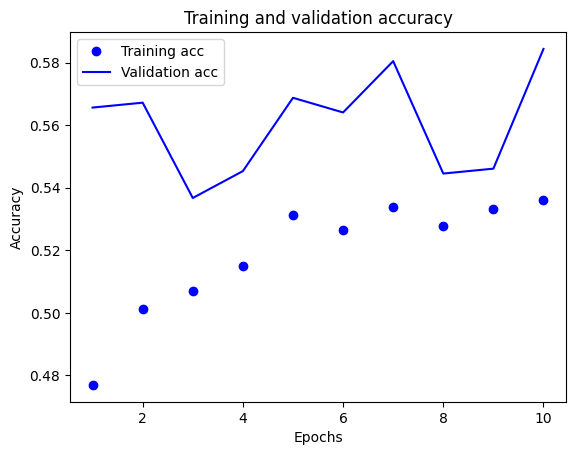

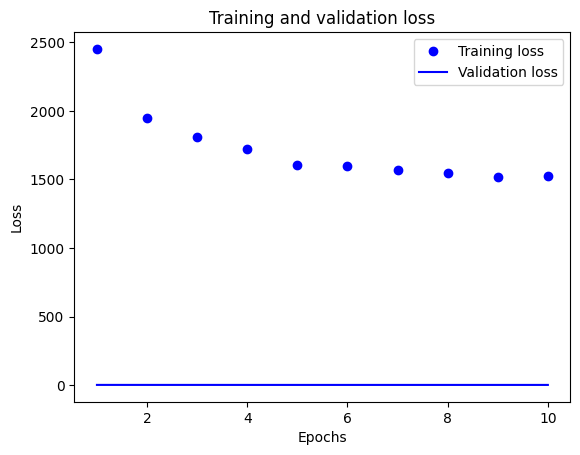

In [ ]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs_x = range(1, len(acc) + 1)

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
predictions = []
labels =  []
for x, y in VALID_DS:
    predictions.append(list(np.argmax(model.predict(x), axis = -1)))
    labels.append(list(y.numpy()))

predictions_final = []
true_labels = []
for l in predictions:
    predictions_final += l
for l in labels:
    true_labels += l

1/1 [==============================] - 0s 198ms/step


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


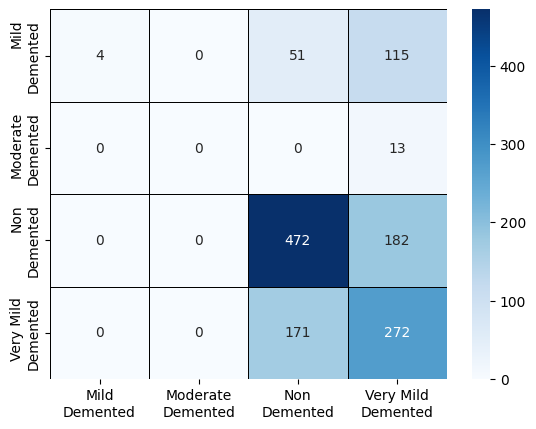

In [ ]:
print(CLASSES)
CLASS_NAMES = ['Mild\nDemented', 'Moderate\nDemented', 'Non\nDemented', 'Very Mild\nDemented']

cm = confusion_matrix(true_labels, predictions_final)
ax = sns.heatmap(data=cm, annot=True, cmap='Blues', fmt='g', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, linecolor='black', linewidth=0.5)
fig = ax.get_figure()
fig.savefig('confusion-matrix_2.pdf', bbox_inches='tight')

In [19]:
# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions_final))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.23      0.36       170
           1       0.00      0.00      0.00        13
           2       0.69      0.86      0.77       654
           3       0.61      0.58      0.59       443

    accuracy                           0.67      1280
   macro avg       0.52      0.42      0.43      1280
weighted avg       0.67      0.67      0.64      1280



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 2

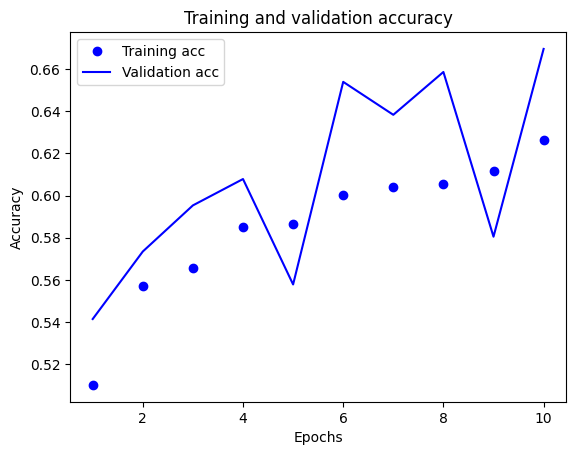

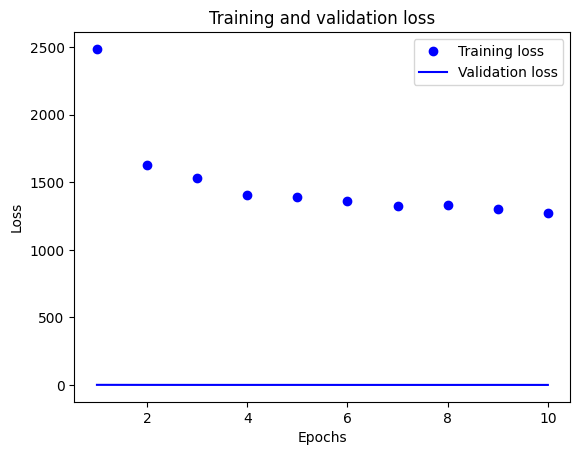

In [15]:
acc = training_history_2.history['accuracy']
val_acc = training_history_2.history['val_accuracy']
loss = training_history_2.history['loss']
val_loss = training_history_2.history['val_loss']

epochs_x = range(1, len(acc) + 1)

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
predictions = []
labels =  []
for x, y in VALID_DS:
    predictions.append(list(np.argmax(model_2.predict(x), axis = -1)))
    labels.append(list(y.numpy()))

predictions_final = []
true_labels = []
for l in predictions:
    predictions_final += l
for l in labels:
    true_labels += l

1/1 [==============================] - 0s 207ms/step


['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


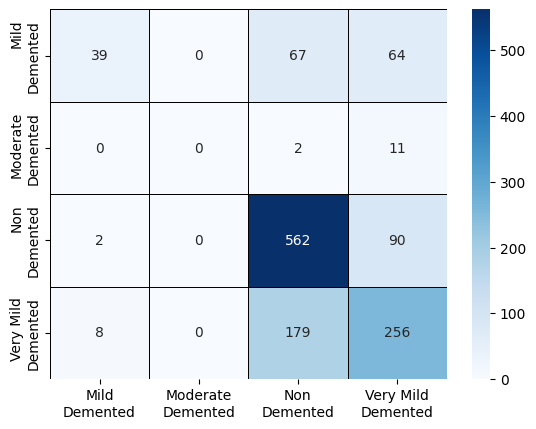

In [18]:
print(CLASSES)
CLASS_NAMES = ['Mild\nDemented', 'Moderate\nDemented', 'Non\nDemented', 'Very Mild\nDemented']

cm = confusion_matrix(true_labels, predictions_final)
ax = sns.heatmap(data=cm, annot=True, cmap='Blues', fmt='g', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, linecolor='black', linewidth=0.5)
fig = ax.get_figure()
fig.savefig('confusion-matrix.pdf', bbox_inches='tight')

In [ ]:
# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions_final))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       170
           1       0.00      0.00      0.00        13
           2       0.68      0.72      0.70       654
           3       0.47      0.61      0.53       443

    accuracy                           0.58      1280
   macro avg       0.54      0.34      0.32      1280
weighted avg       0.64      0.58      0.55      1280



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
